# Dwelling densities of Built Up Areas in England and Wales, 2011 Census
- This notebook uses geography and data from the Office for National Statistics (ONS) to investigate the dwelling density of towns and cities in England and Wales at the time of the 2011 census.
- It uses the ONS's definition of Built Up Areas (BUA).

## 0. Import required libraries

In [1]:
# File management and downloads
from pathlib import Path
from urllib.request import urlretrieve
import requests
# Mapping
import geopandas as gpd
# Data and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Download and process Built Up Area geometry from the Office for National Statistics

- Geometry available here: https://geoportal.statistics.gov.uk/datasets/built-up-areas-december-2011-boundaries-v2-1
- User guidance available here:
https://www.nomisweb.co.uk/articles/ref/builtupareas_userguidance.pdf

In [2]:
# Define the filename for the BUA geometry
BUA_geometry_filename = Path("BUA_geometry.geojson")
# If we don't already have that file
if not BUA_geometry_filename.is_file():
    # Download the file from this location
    BUA_geo_url = "https://opendata.arcgis.com/datasets/210f705366044b8c9ca3fa6f4f83fa5d_0.geojson"
    # and save it (takes a minute or two)
    urlretrieve(BUA_geo_url, BUA_geometry_filename)
    
# Define the filename for the countries geometry (just used as a background for the BUAs)
Countries_geometry_filename = Path("Countries_geometry.geojson")
# If we don't already have that file
if not Countries_geometry_filename.is_file():
    # Download the file from this location
    Countries_geo_url = "https://opendata.arcgis.com/datasets/3d0a732e0b974a05b1766b93e2682d1f_0.geojson"
    # and save it (takes a minute or two)
    urlretrieve(Countries_geo_url, Countries_geometry_filename)

- Load the geometry into GeoPandas and check its contents:

In [3]:
# Read the GeoJSON into a GeoPandas GeoDataFrame
BUA_geo = gpd.read_file('BUA_geometry.geojson')
Countries_geo = gpd.read_file('Countries_geometry.geojson')
# Check the Coordinate Reference System
print("Current CRS:", BUA_geo.crs)
print("Current CRS:", Countries_geo.crs)
# And show the first 2 rows of the BUA data
BUA_geo.head(2)

Current CRS: epsg:4326
Current CRS: epsg:4326


,FID,objectid,bua11cd,bua11nm,bua_id,has_sd,sd_count,urban_bua,st_areasha,st_lengths,Shape__Area,Shape__Length,geometry
0,1,501,E34000501,Compton Martin BUA,1135,N,0,No,280013.222652,4700.0847,716102.439209,7517.774310,"POLYGON ((-2.66136 51.31159, -2.66208 51.31158..."
1,2,1,E34000001,Kexby BUA,3214,N,0,No,202502.812521,4000.0277,567873.607635,6698.030945,"POLYGON ((-0.69110 53.36328, -0.69108 53.36373..."


- Reduce the dataset to the columns of interest:

|   |   |
|---|---|
|bua11cd|The code for each Built Up Area|
|bua11nm|The name for each Built Up Area|
|urban_bua|whether the BUA has a population of 10,000 or more|
|geometry|the geometry for each Built Up Area|

- Rename some of the columns to make them easier to work with.
- Project the geometry to the British National Grid (EPSG:27700) so that we can measure from it.

,BUA Code,BUA Name,Urban,geometry
0,E34000501,Compton Martin BUA,No,"POLYGON ((353999.830 157149.584, 353949.839 15..."
1,E34000001,Kexby BUA,No,"POLYGON ((487199.881 385952.368, 487199.881 38..."


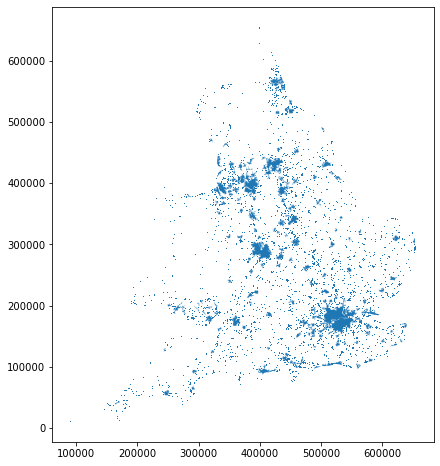

In [4]:
# Reduce the GeoDataFrame to a subset of the columns
BUA_geo = BUA_geo[['bua11cd','bua11nm','urban_bua','geometry']]
# Rename them to something easier to understand
BUA_geo.rename(columns={'bua11cd':'BUA Code', 'bua11nm':'BUA Name', 'urban_bua':'Urban'},
              inplace=True)

# Project the geometry from Web Mercator to British National Grid
BUA_geo.to_crs(epsg=27700, inplace=True)
Countries_geo.to_crs(epsg=27700, inplace=True)

# Show the boundary geometry and  a sample of the reduced dataset
BUA_geo.plot(figsize=(8,8))
BUA_geo.head(2)

## 2. Download and process census data for the Built Up Areas from Nomis

- Nomis publishes information on the number of dwellings and households in each Built Up Area.
- It is available from this page:[https://www.nomisweb.co.uk/census/2011/ks401ew](https://www.nomisweb.co.uk/census/2011/ks401ew).

In [5]:
# Define the filename for the BUA data
BUA_data_filename = Path("KS401EW_BUA.csv")
# If we don't already have the file
if not BUA_data_filename.is_file():
    # use requests to get the data from this address
    url = "https://www.nomisweb.co.uk/api/v01/dataset/nm_618_1.bulk.csv?time=latest&measures=20100&rural_urban=total&geography=TYPE269"
    # keep the response
    response = requests.get(url)
    # write it into the defined filename
    with open('KS401EW_BUA.csv', 'wb') as out:
        out.write(response.content)

- Read the data into Pandas and check the contents

In [6]:
# Read the csv file into a Pandas DataFrame
BUA_data = pd.read_csv('KS401EW_BUA.csv')
# Check the contents of the data
BUA_data.head(2)

,date,geography,geography code,Rural Urban,Dwelling Type: All categories: Dwelling type; measures: Value,Dwelling Type: Unshared dwelling; measures: Value,Dwelling Type: Shared dwelling: Two household spaces; measures: Value,Dwelling Type: Shared dwelling: Three or more household spaces; measures: Value,Dwelling Type: All categories: Household spaces; measures: Value,Dwelling Type: Household spaces with at least one usual resident; measures: Value,Dwelling Type: Household spaces with no usual residents; measures: Value,Dwelling Type: Whole house or bungalow: Detached; measures: Value,Dwelling Type: Whole house or bungalow: Semi-detached; measures: Value,Dwelling Type: Whole house or bungalow: Terraced (including end-terrace); measures: Value,"Dwelling Type: Flat, maisonette or apartment: Purpose-built block of flats or tenement; measures: Value","Dwelling Type: Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits); measures: Value","Dwelling Type: Flat, maisonette or apartment: In a commercial building; measures: Value",Dwelling Type: Caravan or other mobile or temporary structure; measures: Value
0,2011,Kexby BUA,E34000001,Total,150,150,0,0,150,144,6,82,61,6,0,1,0,0
1,2011,Bradfield Heath BUA,E34000002,Total,298,298,0,0,298,286,12,174,81,31,10,2,0,0


- Reduce the columns to a minimum:
    - The total number of dwellings: `Dwelling Type: All categories: Dwelling type; measures: Value`
    - The link to the geometry:`geography code`
- Rename the column to simply `Dwellings`.

In [7]:
BUA_data = BUA_data[['geography code', 'Dwelling Type: All categories: Dwelling type; measures: Value']]
BUA_data.rename(columns={'Dwelling Type: All categories: Dwelling type; measures: Value':'Dwellings',
                        'geography code':'BUA Code'},
               inplace=True)
BUA_data.head(2)

,BUA Code,Dwellings
0,E34000001,150
1,E34000002,298


## 3. Join the data and geometry
- Start with an outer join so as not to lose any data
- Reorder the columns for legibility.

In [8]:
# Merge the geometry and data
BUA_geodata = BUA_geo.merge(BUA_data, left_on='BUA Code', right_on='BUA Code', how='outer')
# Reorder the columns
BUA_geodata = BUA_geodata[['BUA Code', 'BUA Name', 'Dwellings', 'Urban', 'geometry']]
# Show a sample
BUA_geodata.head(3)

,BUA Code,BUA Name,Dwellings,Urban,geometry
0,E34000501,Compton Martin BUA,226.0,No,"POLYGON ((353999.830 157149.584, 353949.839 15..."
1,E34000001,Kexby BUA,150.0,No,"POLYGON ((487199.881 385952.368, 487199.881 38..."
2,E34000502,Hutton BUA,264.0,No,"POLYGON ((502149.299 453502.234, 502149.298 45..."


#### Check for any rows that didn't match
- Filter the merged GeoDataFrame to show a sample of rows that are missing data

In [9]:
BUA_geodata[BUA_geodata.isna().any(axis=1)]

,BUA Code,BUA Name,Dwellings,Urban,geometry
317,E34000315,South Mimms Services,NaN,No,"POLYGON ((522701.652 200000.462, 522651.654 20..."
3063,E34003062,Old Dalby Trading Estate,NaN,No,"POLYGON ((468650.458 324052.295, 468700.456 32..."
5057,E34005058,Daventry International Rail Freight Terminal,NaN,No,"MULTIPOLYGON (((456750.945 273601.842, 456700...."
5058,E34005059,Tunstead Works,NaN,No,"POLYGON ((410000.074 374251.773, 410000.074 37..."
5059,E34005060,Peckleton Common,NaN,No,"POLYGON ((447850.674 301552.026, 447850.674 30..."
...,...,...,...,...,...
5825,W37000455,"Steelworks, nr Newport (Newport)",NaN,No,"POLYGON ((337799.620 186950.173, 337799.620 18..."
5826,W37000456,Mona,NaN,No,"POLYGON ((241349.668 375501.950, 241299.678 37..."
5827,W37000457,"Airfield, nr St Ishmael's",NaN,No,"POLYGON ((179497.477 207351.667, 179547.484 20..."
5828,W37000458,Llanbedr Airfield (disused),NaN,No,"MULTIPOLYGON (((256599.608 326601.803, 256649...."


- Their names (e.g. trading estates, freight terminals, airefields etc.) suggest it is to be expected that they don't contain any dwellings.
- Drop these rows as they don't add anything to this study.

In [10]:
BUA_geodata.dropna(inplace=True)
BUA_geodata[BUA_geodata.isna().any(axis=1)].head(3)

,BUA Code,BUA Name,Dwellings,Urban,geometry


## 4. Measure the area of the BUAs & calculate dwelling density
It is common to discuss housing in terms of dwellings per hectare so:
- Measure the area of the BUAs in hectatres.
- Divide the number of dwellings in each BUA by its area to get the dwelling density.

In [11]:
# Measure the area of the BUAs in hectares
BUA_geodata['Area_ha'] = (BUA_geodata.area/10_000).round(decimals=1)
# Calculate the dwelling density
BUA_geodata['Dwellings_ha'] = (BUA_geodata['Dwellings']/BUA_geodata['Area_ha']).round(decimals=1)
# Show the result
BUA_geodata.head(3)

,BUA Code,BUA Name,Dwellings,Urban,geometry,Area_ha,Dwellings_ha
0,E34000501,Compton Martin BUA,226.0,No,"POLYGON ((353999.830 157149.584, 353949.839 15...",28.0,8.1
1,E34000001,Kexby BUA,150.0,No,"POLYGON ((487199.881 385952.368, 487199.881 38...",20.3,7.4
2,E34000502,Hutton BUA,264.0,No,"POLYGON ((502149.299 453502.234, 502149.298 45...",31.5,8.4


## 5. Show a map of the BUAs coloured by dwelling density

,BUA Code,BUA Name,Dwellings,Urban,geometry,Area_ha,Dwellings_ha
0,E34000501,Compton Martin BUA,226.0,No,"POLYGON ((353999.830 157149.584, 353949.839 15...",28.0,8.1
1,E34000001,Kexby BUA,150.0,No,"POLYGON ((487199.881 385952.368, 487199.881 38...",20.3,7.4


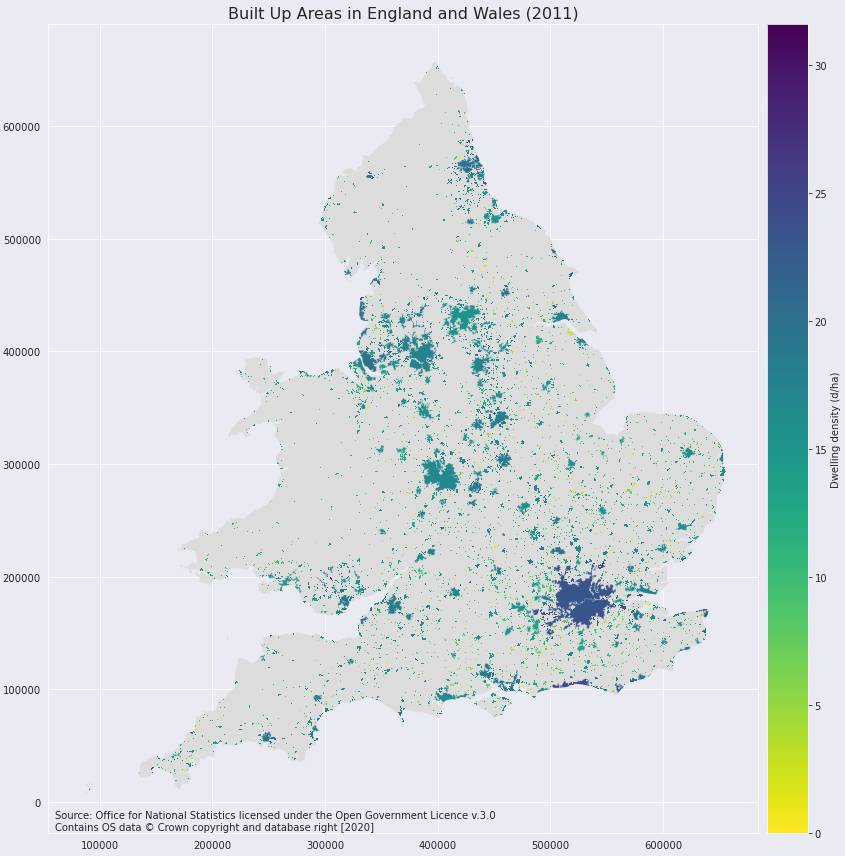

In [20]:
with sns.axes_style("darkgrid", {'figure.facecolor': '#EAEAF2'}):
    fig, ax = plt.subplots(figsize=(13,12))
    # Plot the countries as a background shape
    Countries_geo.plot(ax=ax,
                       color='gainsboro',
                       edgecolor='none',
                      )
    # Plot the BUAs coloured by density
    BUA_geodata.plot(column='Dwellings_ha',
                     cmap='viridis_r',
                     edgecolor='none',
                     vmin=0,
                     legend=True,
                     legend_kwds={'label': "Dwelling density (d/ha)",
                                  'pad':0.01,
                                 },
                     ax=ax,
                    )
    # Give the plot a title
    ax.set_title(label='Built Up Areas in England and Wales (2011)',
                 fontdict={'fontsize':16,
                          })
    # Add the attribution
    ax.text(60000,-25000,"Source: Office for National Statistics licensed under the Open Government Licence v.3.0\nContains OS data © Crown copyright and database right [2020]")
    # Save the file
    fig.tight_layout()
    fig.savefig('BUA_dwelling_density_map.png', facecolor='#EAEAF2')

BUA_geodata.head(2)

## 6. Plot the distribution of the BUA dwelling densities
- Overlay two subsets of the data:
    - BUAs with 10,000 people or more
    - BUAs with 10,000 dwellings or more

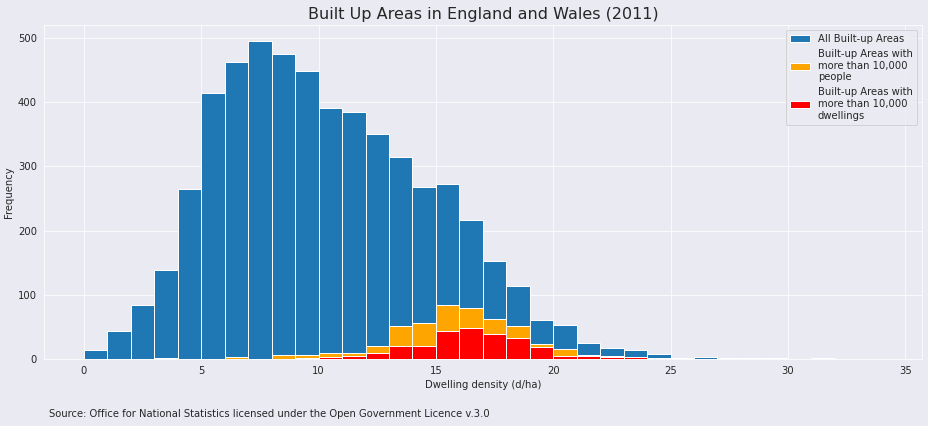

In [13]:
with sns.axes_style("darkgrid", {'figure.facecolor': '#EAEAF2'}):
    fig, ax = plt.subplots(figsize=(13,6))
    
    # Create two subsets of the data
    # One of settlements with 10,000 or more people (based on BUA 'Urban' tag)
    BUA_10_000_people = BUA_geodata[BUA_geodata['Urban']=='Yes']
    # One of settlements with 10,000 or more dwellings
    BUA_10_000_dwellings = BUA_geodata[BUA_geodata['Dwellings']>=10_000]
    
    # Plot histograme of all BUA dwelling densities
    BUA_geodata['Dwellings_ha'].plot(kind='hist',
                                     bins=range(0,35),
                                     legend=True,
                                     label='All Built-up Areas',
                                     ax=ax)
    # Plot histograme of BUA dwelling densities 10,000 people or more
    BUA_10_000_people['Dwellings_ha'].plot(kind='hist',
                                           bins=range(0,35),
                                           color='orange',
                                           ax=ax,
                                           legend=True,
                                           label='Built-up Areas with\nmore than 10,000\npeople')
    # Plot histograme of BUA dwelling densities 10,000 dwellings or more
    BUA_10_000_dwellings['Dwellings_ha'].plot(kind='hist',
                                              bins=range(0,35),
                                              color='red',
                                              ax=ax,
                                              legend=True,
                                              label='Built-up Areas with\nmore than 10,000\ndwellings')
    # Give the plot a title
    ax.set_title(label='Built Up Areas in England and Wales (2011)',
                 fontdict={'fontsize':16,
                          })
    ax.set_xlabel('Dwelling density (d/ha)')
    # Add the attribution
    ax.text(-1.5,-90,"Source: Office for National Statistics licensed under the Open Government Licence v.3.0")
    # Save the file
    fig.tight_layout()
    fig.savefig('BUA_dwelling_density_distribution.png', facecolor='#EAEAF2')

## 7. Check the summary statistics
- All BUAs
- BUAs with 10,000 people or more
- BUAs with 10,000 dwellings or more

In [14]:
BUA_geodata.describe().round()

,Dwellings,Area_ha,Dwellings_ha
count,5493.0,5493.0,5493.0
mean,4217.0,263.0,10.0
std,60985.0,2839.0,5.0
min,42.0,20.0,0.0
25%,225.0,28.0,7.0
50%,408.0,45.0,10.0
75%,1065.0,99.0,14.0
max,4035768.0,173790.0,32.0


In [15]:
BUA_10_000_people.describe().round()

,Dwellings,Area_ha,Dwellings_ha
count,494.0,494.0,494.0
mean,39938.0,2260.0,16.0
std,200050.0,9239.0,3.0
min,2995.0,187.0,3.0
25%,6710.0,455.0,14.0
50%,10264.0,688.0,16.0
75%,22445.0,1445.0,18.0
max,4035768.0,173790.0,28.0


In [16]:
BUA_10_000_dwellings.describe().round()

,Dwellings,Area_ha,Dwellings_ha
count,255.0,255.0,255.0
mean,71000.0,3941.0,17.0
std,275086.0,12640.0,2.0
min,10008.0,462.0,10.0
25%,13854.0,869.0,15.0
50%,22094.0,1379.0,16.0
75%,51252.0,2819.0,18.0
max,4035768.0,173790.0,25.0


## 8. Plot dwelling density against the area of the BUAs

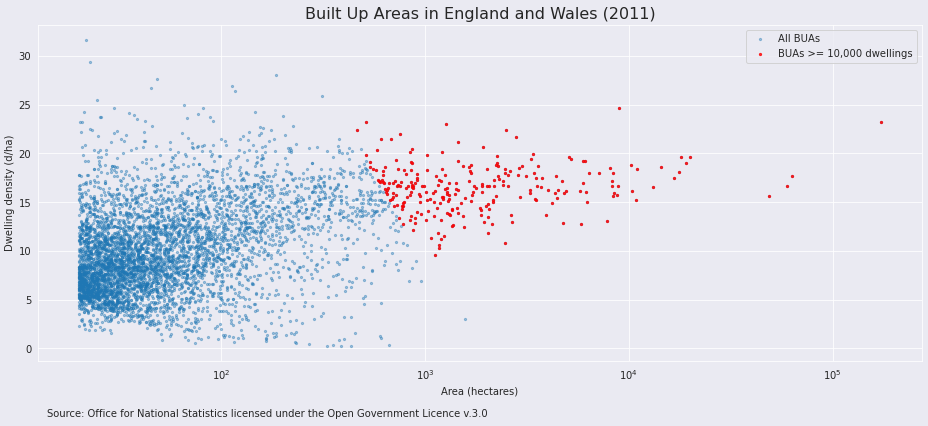

In [17]:
with sns.axes_style("darkgrid", {'figure.facecolor': '#EAEAF2'}):
    fig, ax = plt.subplots(figsize=(13,6))
    
    # Use a log scale on the x axis  to get a better spread for the smaller BUAs
    ax.set(xscale="log")

    BUA_geodata[['Area_ha','Dwellings_ha']].plot(x='Area_ha',
                                                 y='Dwellings_ha',
                                                 kind='scatter',
                                                 s=5,
                                                 alpha=0.4,
                                                 label='All BUAs',
                                                 ax=ax)
    BUA_10_000_dwellings[['Area_ha','Dwellings_ha']].plot(x='Area_ha',
                                                          y='Dwellings_ha',
                                                          kind='scatter',
                                                          c='red',
                                                          s=5,
                                                          alpha=0.8,
                                                          label='BUAs >= 10,000 dwellings',
                                                          ax=ax)
    # Give the plot a title & label the axes
    ax.set_title(label='Built Up Areas in England and Wales (2011)',
                 fontdict={'fontsize':16,
                          })
    ax.set_xlabel('Area (hectares)')
    ax.set_ylabel('Dwelling density (d/ha)')
    # Add the attribution
    ax.text(14,-7,"Source: Office for National Statistics licensed under the Open Government Licence v.3.0")
    # Save the file
    fig.tight_layout()
    fig.savefig('BUA_dwelling_density_by_area.png', facecolor='#EAEAF2')

## 9. Extract the single row for London

In [18]:
BUA_geodata[BUA_geodata['BUA Name'].str.contains('Greater London')]

,BUA Code,BUA Name,Dwellings,Urban,geometry,Area_ha,Dwellings_ha
4706,E34004707,Greater London BUA,4035768.0,Yes,"MULTIPOLYGON (((494951.269 160099.919, 494951....",173789.7,23.2
